In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
directory_in_str = "./data/"
directory = os.fsencode(directory_in_str)
data = []
for filename in os.listdir(directory):
    df_temp = pd.read_csv(directory_in_str+filename.decode('utf-8'),sep=';',index_col=0,parse_dates=True)
    df_temp['week_day'] = filename.decode('utf-8').split(".")[0]
    data.append(df_temp)
df = pd.concat(data)

In [3]:
df.shape

(24877, 3)

In [4]:
df.head()

,customer_no,location,week_day
timestamp,,,
2019-09-06 07:00:00,1,dairy,friday
2019-09-06 07:00:00,2,drinks,friday
2019-09-06 07:00:00,3,fruit,friday
2019-09-06 07:01:00,2,checkout,friday
2019-09-06 07:01:00,4,drinks,friday


## Data Exploration

#### 1. Calculate the total number of customers in each section

In [5]:
df.groupby(['location'])['customer_no'].count()

location
checkout    7417
dairy       4679
drinks      3905
fruit       5122
spices      3754
Name: customer_no, dtype: int64

#### 2. Calculate the total number of customers in each section over time

In [6]:
groupby_df = df.reset_index().groupby(['timestamp','location'],as_index=False)['customer_no'].count()

In [7]:
groupby_df.rename(columns={'customer_no':'num_of_customers'},inplace=True)

In [8]:
groupby_df.head()

,timestamp,location,num_of_customers
0,2019-09-02 07:03:00,dairy,2
1,2019-09-02 07:04:00,dairy,2
2,2019-09-02 07:04:00,fruit,1
3,2019-09-02 07:04:00,spices,3
4,2019-09-02 07:05:00,checkout,2


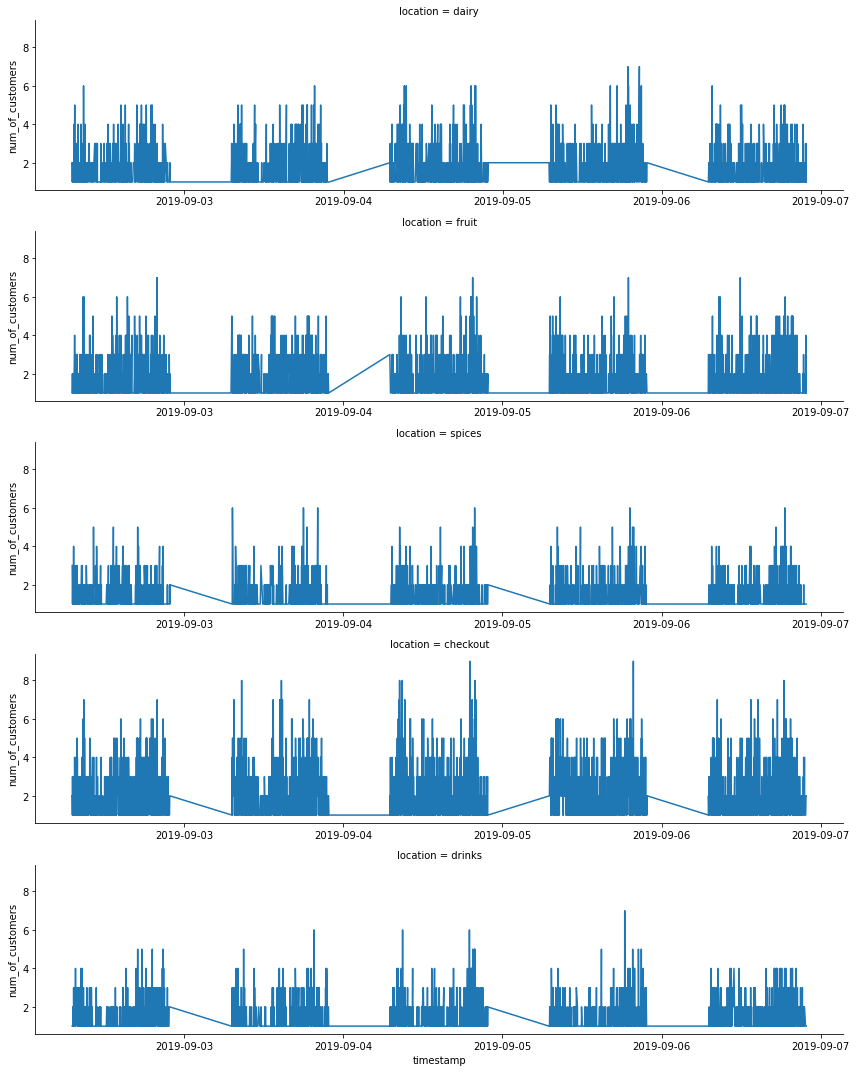

In [12]:
#Plotting for all locations
#groupby_df.set_index('timestamp',inplace=True)
g = sns.FacetGrid(groupby_df, row="location",aspect=4,sharex=False)
#g.map(groupby_df['num_of_customers'].resample('0.5H').count().plot)
g.map(sns.lineplot,'timestamp','num_of_customers')

#### 3. Display the number of customers at checkout over time

<AxesSubplot:xlabel='timestamp'>

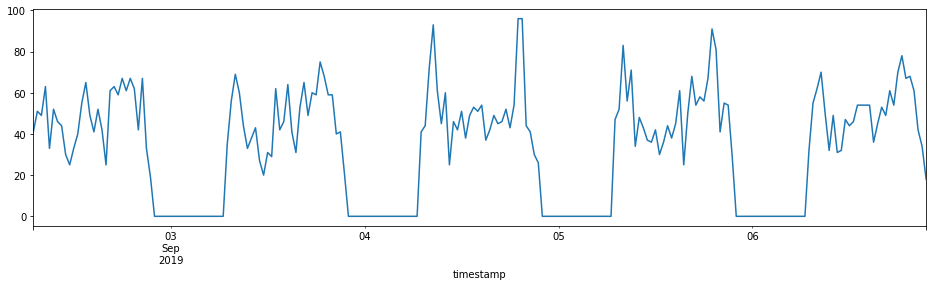

In [13]:
df_checkout= df[df['location']=='checkout']
plt.figure(figsize=(16,4))
df_checkout['customer_no'].resample('0.5H').count().plot()

#### 4. Calculate the time each customer spent in the market

In [14]:
result = df.reset_index().groupby(['week_day','customer_no'])['timestamp'].agg([lambda x: (x.max() - x.min()).total_seconds()/60]).rename(columns={'<lambda>': 'time_spent(mins)'})

In [15]:
result.head()

time_spent(mins)
week_day customer_no                  
friday   1                         5.0
         2                         1.0
         3                        11.0
         4                         1.0
         5                        14.0

In [18]:
result.groupby('week_day').max()

,time_spent(mins)
week_day,
friday,52.0
monday,51.0
thursday,52.0
tuesday,37.0
wednesday,51.0


#### 5. Calculate the total number of customers in the supermarket over time.

In [19]:
df.head()

,customer_no,location,week_day
timestamp,,,
2019-09-06 07:00:00,1,dairy,friday
2019-09-06 07:00:00,2,drinks,friday
2019-09-06 07:00:00,3,fruit,friday
2019-09-06 07:01:00,2,checkout,friday
2019-09-06 07:01:00,4,drinks,friday


In [25]:
df_uniques=df.drop_duplicates(['customer_no','week_day'])

<AxesSubplot:xlabel='timestamp'>

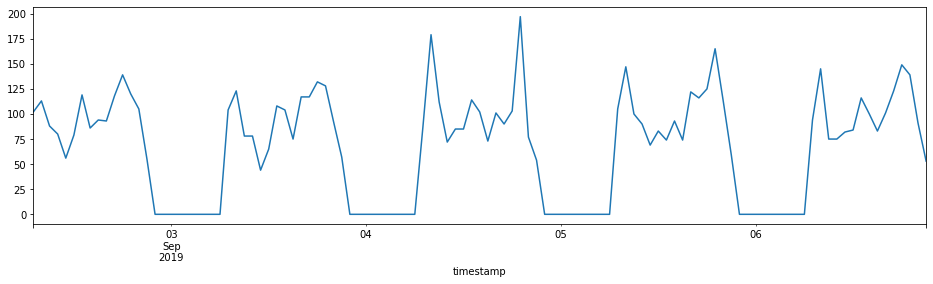

In [29]:
plt.figure(figsize=(16,4))
df_uniques.resample('1H')['customer_no'].count().plot()

In [33]:
df_uniques[df_uniques['week_day']=='monday']

,customer_no,location,week_day
timestamp,,,
2019-09-02 07:03:00,1,dairy,monday
2019-09-02 07:03:00,2,dairy,monday
2019-09-02 07:04:00,3,dairy,monday
2019-09-02 07:04:00,4,dairy,monday
2019-09-02 07:04:00,5,spices,monday
...,...,...,...
2019-09-02 21:47:00,1443,fruit,monday
2019-09-02 21:48:00,1444,spices,monday
2019-09-02 21:49:00,1445,dairy,monday


#### 6. Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

In [41]:
df[(df['customer_no']==1200)&(df['week_day']=='monday')]

,customer_no,location,week_day
timestamp,,,
2019-09-02 19:14:00,1200,fruit,monday
2019-09-02 19:15:00,1200,checkout,monday


In [55]:
new_df = df.groupby(['week_day','customer_no'],as_index=False)['location'].agg(['first',lambda x:list(x)[1:]]).rename(columns={'<lambda_0>':'following'})

In [58]:
new_df.tail(10)

first           following
week_day  customer_no                            
wednesday 1522          dairy          [checkout]
          1523          fruit          [checkout]
          1524          dairy  [drinks, checkout]
          1525         spices  [drinks, checkout]
          1526         drinks          [checkout]
          1527          dairy     [drinks, fruit]
          1528         drinks            [spices]
          1529         spices      [fruit, dairy]
          1530          dairy     [spices, fruit]
          1531         drinks          [checkout]

<AxesSubplot:xlabel='first', ylabel='count'>

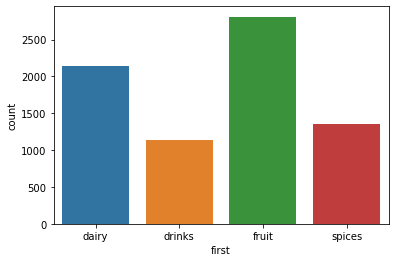

In [59]:
sns.countplot(data=new_df,x='first')